In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm
from matplotlib import ticker, cm 
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import os, sys
import scipy.io.netcdf as nc
import netCDF4
from scipy.interpolate import PchipInterpolator
import getGfileDict
# from omfit_classes import omfit_eqdsk
# from omfit_classes import utils_fusion
import equilibrium_process as eqdsk

In [2]:
cql_nc = netCDF4.Dataset('cql3d.nc',mmap=False )

In [3]:
# Modules
#from transport_world.run_TORIC.output_utils import toric_tools

import toric_tools

# Enables automatic reloading of modules
%reload_ext autoreload
%autoreload 2

In [4]:
toric_nc = netCDF4.Dataset('fort.21')

In [5]:
toric = toric_tools.toric_analysis(
    toric_name='fort.21',#'/home/vandelij/conor_toric/forJACOB/toric.ncdf',
    #toric_name='/home/vandelij/conor_toric/forJACOB/toric.ncdf',#'/home/cjperks/2201_Pumpout/CMOD/shots/1140221013/toric_test.ncdf',
    mode='ICRF',
    path='/home/vandelij/conor_toric/forJACOB/'   #'/home/cjperks/2201_Pumpout/CMOD/shots/1140221013/'
    )

Non-CRITICAL:  /home/vandelij/conor_toric/forJACOB/toric_qlde.cdf  not found.


In [6]:
print(cql_nc.variables.keys())
print(toric_nc.variables.keys())
print(toric.cdf_hdl.variables.keys())


dict_keys(['version', 'mnemonic', 'ampfmod', 'urfmod', 'rdcmod', 'frmod', 'beamplse', 'transp', 'tavg', 'f4d_out', 'netcdfshort', 'eqdskin', 'ngen', 'ntotal', 'kspeci', 'bnumb', 'fmass', 'lrzmax', 'radcoord', 'rya', 'Rp', 'Rm', 'rhomax', 'radmaj', 'rpmconz', 'btor', 'toteqd', 'rgeomp', 'r0geomp', 'rmag', 'zmag', 'eqsym', 'zshift', 'eps0', 'elong', 'zgeomp', 'rgeom1', 'rgeom2', 'area', 'darea', 'vol', 'dvol', 'equilpsi', 'psivalm', 'dpsi', 'psimag', 'psilim', 'h_r', 'qsafety', 'curreq', 'lrz', 'lrindx', 'jx', 'x', 'enerkev', 'uoc', 'dx', 'cint2', 'vnorm', 'enorm', 'iy', 'y', 'dy', 'cynt2', 'iy_', 'itl', 'itu', 'lz', 'z', 'dz', 'solrz', 'solzz', 'pol', 'bbpsi', 'imax', 'lmax', 'zboun', 'zmaxpsi', 'tau', 'dtau', 'beampon', 'beampoff', 'tavg1', 'tavg2', 'ndeltarho', 'bthr', 'btoru', 'btor0', 'bmidplne', 'efflag', 'softxry', 'ipronn', 'gamafac', 'pellet', 'imp_type', 'nstates', 'fmass_imp', 'pellet_M0', 'pellet_Cablation', 'npa_diag', 'sigmamod', 'isigmas', 'mmsv', 'isigsgv1', 'isigsgv2', '

In [7]:
# Plots the electron absorbed power from FW
# %matplotlib inline
# toric.plotpower()

In [8]:
# # Plots the electron absorbed power from IBW
# toric.plotpower(power='PwEIBW')

In [9]:
# Plots the ion absorbed power from fundamental for species 2
# toric.plotpower(power='PwIF', species=4)

(462,)
total power He3:  87.60209394144692
(462,)


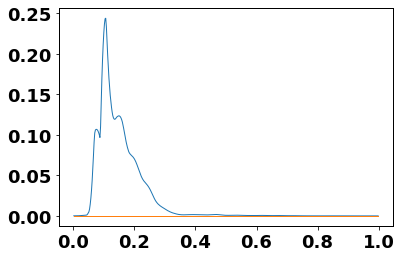

In [10]:
sqrt_pol = toric.cdf_hdl.variables['Pw_abscissa'][:]
print(sqrt_pol.shape)
species_index=4
power_He3_pol = toric.cdf_hdl.variables['PwIF'][:, species_index-1]
total_power_He3 = toric.cdf_hdl.variables['TPwIF'][species_index-1]

power_He3_IH = toric.cdf_hdl.variables['PwIH'][:, species_index-1]
print('total power He3: ', total_power_He3)
print(power_He3_pol.shape)
#print(power_He3_pol)
#print(sqrt_pol)
plt.plot(sqrt_pol, power_He3_pol)
plt.plot(sqrt_pol, power_He3_IH)


In [11]:
MWabs = 40 # this value determines how much power was absorbed 

Total RF power to ions:  26.9196 MW
Total NB power to ions:  0.0 MW


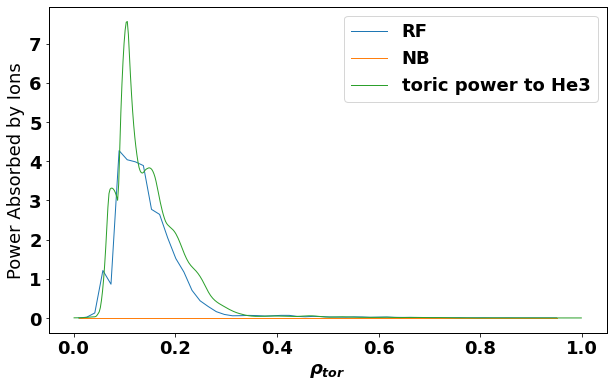

In [12]:
plt.figure(figsize=(10,6))
rya = cql_nc.variables["rya"][:]
dvol = cql_nc.variables['dvol'][:]
powers = cql_nc.variables['powers'][-1, 0, :, :]
powers_RF = powers[4, :]
powers_NB = powers[5, :]
plt.plot(rya, powers_RF, label='RF')
plt.plot(rya, powers_NB, label='NB')

total_RF_power_to_ions = np.trapz(powers_RF*dvol*(1/100)**3)
total_NB_power_to_ions = np.trapz(powers_NB*dvol*(1/100)**3)
print('Total RF power to ions: ', np.round(total_RF_power_to_ions, 4), 'MW')
print('Total NB power to ions: ', np.round(total_NB_power_to_ions, 4), 'MW')
plt.ylabel('Power Absorbed by Ions')
plt.xlabel(r'$\rho_{tor}$')

plt.plot(sqrt_pol, power_He3_pol*31, label='toric power to He3')
plt.legend()

total He3 power fundimental:  87.60209394144692
total He3 power 1st harmonic:  0.0


Text(0.5, 1.0, 'He3')

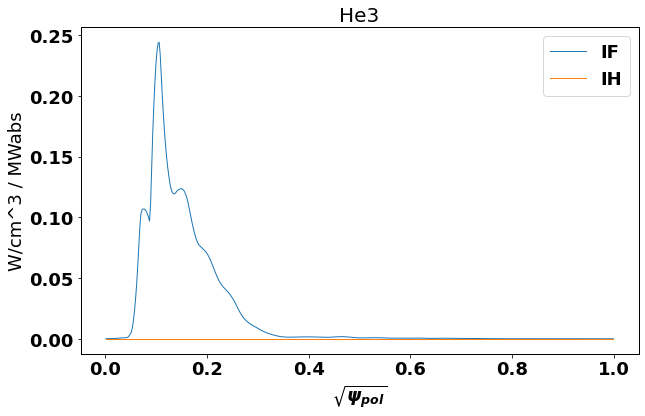

In [13]:
# Meat and potatoes. Calculate the profiles over rho_pol to 
# 1. Each ion species, fundimental
# 2. Each ion species, 1st Harmonic
# 3. Electrons, Fast Wave
# 4. Electrons, IB wave
plt.figure(figsize=(10,6))
species = ['D', 'T', 'Kr', 'He3']
# Species 4: He3
species_index = 4
power_He3_IF_pol = toric.cdf_hdl.variables['PwIF'][:, species_index-1]
total_power_He3_IF = toric.cdf_hdl.variables['TPwIF'][species_index-1]
power_He3_IH_pol = toric.cdf_hdl.variables['PwIH'][:, species_index-1]
total_power_He3_IH = toric.cdf_hdl.variables['TPwIH'][species_index-1]
print('total He3 power fundimental: ', total_power_He3_IF)
print('total He3 power 1st harmonic: ', total_power_He3_IH)

plt.plot(sqrt_pol, power_He3_IF_pol, label='IF')
plt.plot(sqrt_pol, power_He3_IH_pol, label='IH')
plt.xlabel(r'$\sqrt{\psi_{pol}}$')
plt.ylabel('W/cm^3 / MWabs')
plt.legend()
plt.title(species[species_index-1])

total D power fundimental:  0.04741173240332704
total D power 1st harmonic:  0.0


Text(0.5, 1.0, 'D')

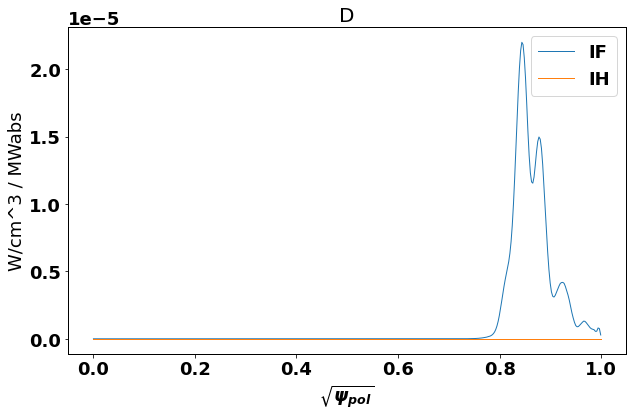

In [14]:
# Species 1: D
plt.figure(figsize=(10,6))
species_index = 1
power_D_IF_pol = toric.cdf_hdl.variables['PwIF'][:, species_index-1]
total_power_D_IF = toric.cdf_hdl.variables['TPwIF'][species_index-1]
power_D_IH_pol = toric.cdf_hdl.variables['PwIH'][:, species_index-1]
total_power_D_IH = toric.cdf_hdl.variables['TPwIH'][species_index-1]
print('total D power fundimental: ', total_power_D_IF)
print('total D power 1st harmonic: ', total_power_D_IH)

plt.plot(sqrt_pol, power_D_IF_pol, label='IF')
plt.plot(sqrt_pol, power_D_IH_pol, label='IH')
plt.xlabel(r'$\sqrt{\psi_{pol}}$')
plt.ylabel('W/cm^3 / MWabs')
plt.legend()
plt.title(species[species_index-1])

total T power fundimental:  0.04741173240332704
total T power 1st harmonic:  0.0


Text(0.5, 1.0, 'T')

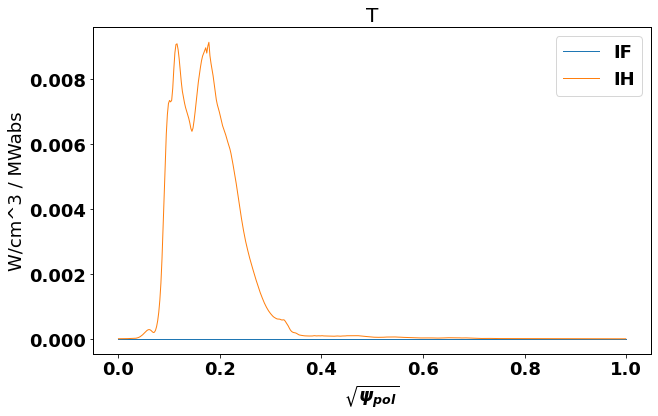

In [15]:
# Species 2: T
plt.figure(figsize=(10,6))
species_index = 2
power_T_IF_pol = toric.cdf_hdl.variables['PwIF'][:, species_index-1]
total_power_T_IF = toric.cdf_hdl.variables['TPwIF'][species_index-1]
power_T_IH_pol = toric.cdf_hdl.variables['PwIH'][:, species_index-1]
total_power_T_IH = toric.cdf_hdl.variables['TPwIH'][species_index-1]
print('total T power fundimental: ', total_power_D_IF)
print('total T power 1st harmonic: ', total_power_D_IH)

plt.plot(sqrt_pol, power_T_IF_pol, label='IF')
plt.plot(sqrt_pol, power_T_IH_pol, label='IH')
plt.xlabel(r'$\sqrt{\psi_{pol}}$')
plt.ylabel('W/cm^3 / MWabs')
plt.legend()
plt.title(species[species_index-1])

total Kr power fundimental:  0.04741173240332704
total Kr power 1st harmonic:  0.0


Text(0.5, 1.0, 'Kr')

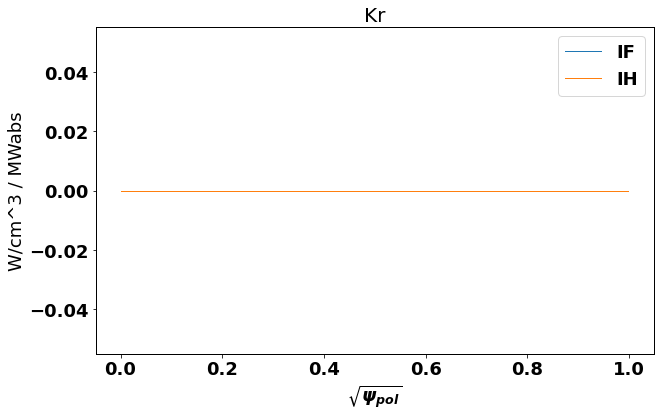

In [16]:
# Species 3: Kr
plt.figure(figsize=(10,6))
species_index = 3
power_Kr_IF_pol = toric.cdf_hdl.variables['PwIF'][:, species_index-1]
total_power_Kr_IF = toric.cdf_hdl.variables['TPwIF'][species_index-1]
power_Kr_IH_pol = toric.cdf_hdl.variables['PwIH'][:, species_index-1]
total_power_Kr_IH = toric.cdf_hdl.variables['TPwIH'][species_index-1]
print('total Kr power fundimental: ', total_power_D_IF)
print('total Kr power 1st harmonic: ', total_power_D_IH)

plt.plot(sqrt_pol, power_Kr_IF_pol, label='IF')
plt.plot(sqrt_pol, power_Kr_IH_pol, label='IH')
plt.xlabel(r'$\sqrt{\psi_{pol}}$')
plt.ylabel('W/cm^3 / MWabs')
plt.legend()
plt.title(species[species_index-1])

total e power fast wave:  [5.43391784]
total e power IBW:  [0.66904913]


Text(0.5, 1.0, 'electrons')

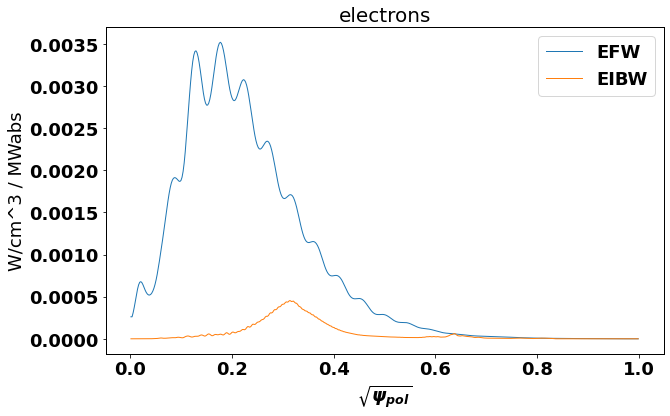

In [17]:
# Electrons
# Species 2: T
plt.figure(figsize=(10,6))
power_e_EFW_pol = toric.cdf_hdl.variables['PwE'][:]
total_power_e_EFW = toric.cdf_hdl.variables['TPwEFW'][:]
power_e_EIBW_pol = toric.cdf_hdl.variables['PwEIBW'][:]
total_power_e_EIBW = toric.cdf_hdl.variables['TPwEIBW'][:]
print('total e power fast wave: ', total_power_e_EFW)
print('total e power IBW: ', total_power_e_EIBW)

plt.plot(sqrt_pol, power_e_EFW_pol, label='EFW')
plt.plot(sqrt_pol, power_e_EIBW_pol, label='EIBW')
plt.xlabel(r'$\sqrt{\psi_{pol}}$')
plt.ylabel('W/cm^3 / MWabs')
plt.legend()
plt.title('electrons')

Total He3 power to maxwell e:  -2.0624 MW
Total He3 power to maxwell ions:  -20.494 MW
60


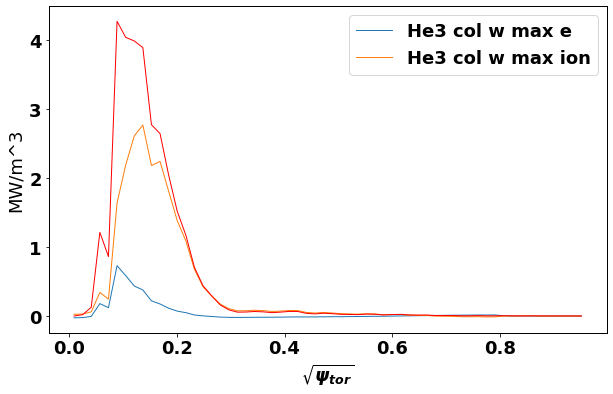

In [18]:
# now, use cql3d to figure out how much He3 power partitions into the bulk 
plt.figure(figsize=(10,6))
powers_to_max_e = powers[0, :]
plt.plot(rya, -1*powers_to_max_e, label='He3 col w max e')
total_RF_power_to_max_e = np.trapz(powers_to_max_e*dvol*(1/100)**3)
print('Total He3 power to maxwell e: ', np.round(total_RF_power_to_max_e, 4), 'MW')


powers_to_max_ions = powers[1, :]
plt.plot(rya, -1*powers_to_max_ions, label='He3 col w max ion')
total_RF_power_to_max_ions = np.trapz(powers_to_max_ions*dvol*(1/100)**3)
print('Total He3 power to maxwell ions: ', np.round(total_RF_power_to_max_ions, 4), 'MW')
plt.xlabel(r'$\sqrt{\psi_{tor}}$')
plt.ylabel('MW/m^3')

plt.plot(rya, powers_RF, 'r-')
plt.legend()

frac_He3_power_to_ions = powers_to_max_ions / powers_RF
frac_He3_power_to_electrons = powers_to_max_e / powers_RF
print(len(powers_to_max_ions))

ips-eqdsk.geq


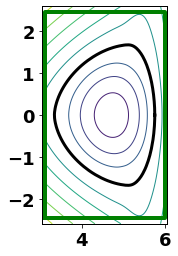

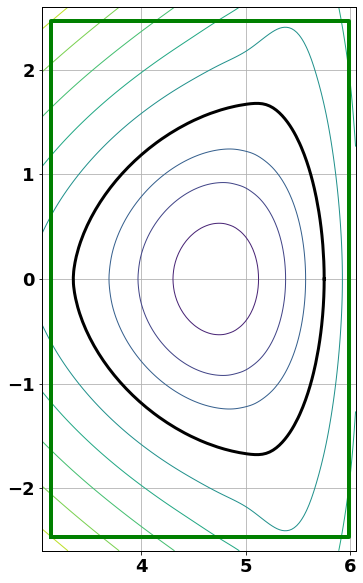

In [19]:
eqdsk_file='ips-eqdsk.geq'
print(eqdsk_file)
eq0,fig0=eqdsk.readGEQDSK(eqdsk_file,doplot=True,dolimiter=True);
plt.figure(fig0)
fig0.set_size_inches(10,10)
ax=fig0.get_axes()[0]
ax.grid()

In [20]:

# gfile='ips-eqdsk.geq'
# equig_file = 'ips-eqdsk.geq.equigs'
# geqxpl_output= !geqxpl @equigs_gen/g_filename=$gfile"/equigs_filename="$equigs_file


In [21]:
# geqxpl_output

In [22]:
# # print(rya)
# # print('--')
# # print(sqrt_pol)
# equigs_file = 'ips-eqdsk.geq'
# #eqdsk = getGfileDict.getGfileDict(equigs_file)
# gfile = omfit_eqdsk.OMFITgeqdsk(equigs_file)
# #toric.read_equigs(equigsfile=equigs_file)
# #print(toric.equigs.keys())
# #print(eqdsk.keys())
# rho_pol = np.sqrt(gfile['AuxQuantities']['PSI_NORM'])
# rho_tor = np.sqrt(gfile['AuxQuantities']['PHI_NORM'])
# rhopol = toric.equigs['srad'][:]
# rhotor = toric.equigs['rhotor']
# print(rhotor)

# map_tor_to_pol = interp1d(rhotor,rhopol,kind='cubic',bounds_error=False,fill_value=0.0)


In [23]:
# Renormalize cql3d to toric estimated energy controbutions
# TODO: ONLY RUN IN CQL#D DUBIOUS
He3_frac_toric = 0.8761

alpha = -40*0.87/(np.trapz((powers_to_max_e + powers_to_max_ions)*dvol*(1/100)**3))
print(alpha)

total_RF_power_to_max_ions = total_RF_power_to_max_ions*alpha
print('Total He3 power to maxwell ions: ', np.round(total_RF_power_to_max_ions, 4), 'MW')
total_RF_power_to_max_e = total_RF_power_to_max_e*alpha
print('Total He3 power to maxwell e: ', np.round(total_RF_power_to_max_e, 4), 'MW')

powers_to_max_e = powers_to_max_e * alpha
powers_to_max_ions = powers_to_max_ions*alpha


1.5427973370943395
Total He3 power to maxwell ions:  -31.6182 MW
Total He3 power to maxwell e:  -3.1818 MW


60
60
60


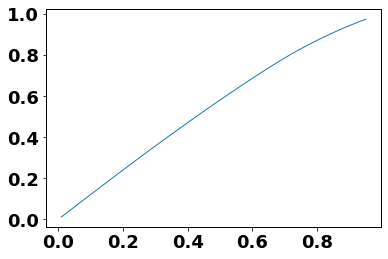

In [24]:
# convert rya (rho_tor to rho_pol)
rya = cql_nc.variables["rya"][:]
def convert(rho1,rho2,prof1):
    prof1fun = PchipInterpolator(rho1,prof1)
    rhoconvfun = PchipInterpolator(rho2,rho1)
    prof2 = prof1fun(rhoconvfun(rho2))
    prof2fun = PchipInterpolator(rho2,prof2)
    #assert np.all(prof1fun(rho1)-prof2fun(rho2) == 0)
    return prof2fun

# tor_to_pol = PchipInterpolator(rya, sqrt_pol)
# rya_pol = tor_to_pol(rya)
rhopol = np.loadtxt('rhopol.txt')
rhotor = np.loadtxt('rhotor.txt')

map_tor_to_pol = PchipInterpolator(rhotor, rhopol)
map_pol_to_tor = PchipInterpolator(rhopol, rhotor)
rya_pol = map_tor_to_pol(rya)
print(len(rya_pol))
powers_to_max_e_pol = -convert(rya, rya_pol, powers_to_max_e)(sqrt_pol)
print(len(powers_to_max_ions))
print(len(rya_pol))
powers_to_max_ions_pol = -convert(rya, rya_pol, powers_to_max_ions)(sqrt_pol)

plt.plot(rya,rya_pol)

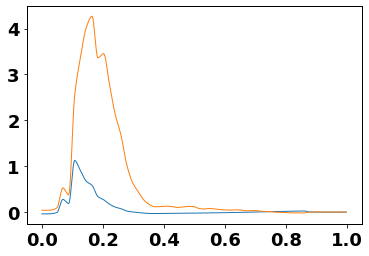

In [25]:
plt.plot(sqrt_pol, powers_to_max_e_pol)
plt.plot(sqrt_pol, powers_to_max_ions_pol)

total power to electrons:  [5.62302841] MW


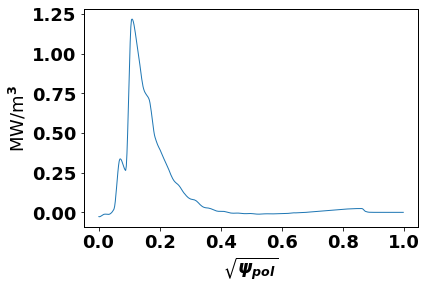

In [26]:
# now, start adding together all controbutions to ions and electrons and save to file. 
MWabs = 40

# electron power = fast wave + IBW + slowing down of He3
electron_power_array = (power_e_EFW_pol + power_e_EIBW_pol)*MWabs + powers_to_max_e_pol

plt.plot(sqrt_pol, electron_power_array)
plt.xlabel(r'$\sqrt{\psi_{pol}}$')
plt.ylabel(r'MW/m$^3$')
total_electron_heating = -total_RF_power_to_max_e + MWabs*(total_power_e_EFW + total_power_e_EIBW)/100
print('total power to electrons: ', total_electron_heating, 'MW')


Total bulk ion heating:  34.13613401638099 MW


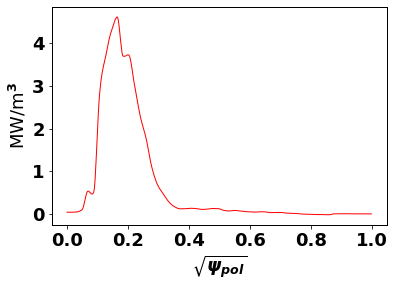

In [27]:
ion_power_array = MWabs*(power_T_IF_pol + power_T_IH_pol +
                         power_D_IF_pol + power_D_IH_pol +
                         power_Kr_IF_pol + power_Kr_IH_pol) + powers_to_max_ions_pol

plt.plot(sqrt_pol, ion_power_array, color='red')
plt.xlabel(r'$\sqrt{\psi_{pol}}$')
plt.ylabel(r'MW/m$^3$')

total_ion_heating = MWabs*(total_power_D_IF + total_power_D_IH+
                           total_power_T_IF + total_power_T_IH+
                           total_power_Kr_IF + total_power_Kr_IH)/100 + -total_RF_power_to_max_ions

print('Total bulk ion heating: ', total_ion_heating, 'MW')



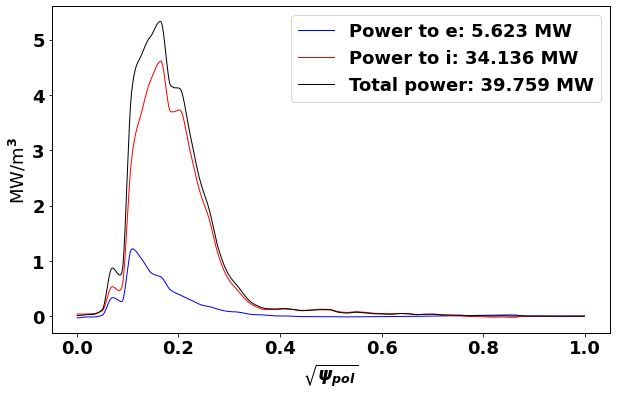

In [28]:
plt.figure(figsize=(10,6))
tot_e = str(round(total_electron_heating[0], 3))
labele = 'Power to e: ' + tot_e + ' MW'

tot_i = str(round(total_ion_heating, 3))
labeli = 'Power to i: ' + tot_i + ' MW'

tot_tot = str(round(total_ion_heating + total_electron_heating[0], 3))
labeltot = 'Total power: ' + tot_tot + ' MW'

plt.plot(sqrt_pol, electron_power_array, color='blue', label=labele)
plt.plot(sqrt_pol, ion_power_array, color='red', label=labeli)

plt.plot(sqrt_pol, electron_power_array + ion_power_array, color='black', label=labeltot)

plt.xlabel(r'$\sqrt{\psi_{pol}}$')
plt.ylabel(r'MW/m$^3$')
plt.legend()

#plt.plot(rya, -1*powers_to_max_ions)

In [29]:
savemat = np.zeros((sqrt_pol.shape[0], 3))
savemat[:, 0] = sqrt_pol
savemat[:, 1] = ion_power_array
savemat[:, 2] = electron_power_array

np.savetxt('Rf_heating.txt', savemat)


In [35]:
# save as toroidal flux txt file 
sqrt_tor = map_pol_to_tor(sqrt_pol)
ion_power_array_tor = convert(sqrt_pol, sqrt_tor, ion_power_array)(sqrt_tor)
electron_power_array_tor = convert(sqrt_pol, sqrt_tor, electron_power_array)(sqrt_tor)
savemat = np.zeros((sqrt_pol.shape[0], 3))
savemat[:, 0] = sqrt_tor
savemat[:, 1] = ion_power_array_tor
savemat[:, 2] = electron_power_array_tor

np.savetxt('Rf_heating_tor.txt', savemat)

In [39]:
# Save as toroidal flux on Haley's grid 
rho_tor_hal = np.linspace(0,1,201)
ion_power_array_tor_hal = convert(sqrt_pol, sqrt_tor, ion_power_array)(rho_tor_hal)
electron_power_array_tor_hal = convert(sqrt_pol, sqrt_tor, electron_power_array)(rho_tor_hal)
savemat = np.zeros((rho_tor_hal.shape[0], 3))
savemat[:, 0] = rho_tor_hal
savemat[:, 1] = ion_power_array_tor_hal
savemat[:, 2] = electron_power_array_tor_hal

np.savetxt('Rf_heating_tor_haleygrid.txt', savemat)

In [34]:
sqrt_tor = map_pol_to_tor(sqrt_pol)
ion_power_array_tor = convert(sqrt_pol, sqrt_tor, ion_power_array)(rya)
electron_power_array_tor = convert(sqrt_pol, sqrt_tor, electron_power_array)(rya)

check_total_poweri = np.trapz(ion_power_array_tor*dvol*(1/100)**3) 
check_total_powere = np.trapz(electron_power_array_tor*dvol*(1/100)**3)

print('Check total i power: ', check_total_poweri)
print('Check total e power: ', check_total_powere)
print('Check total i + e power: ', check_total_poweri + check_total_powere)

Check total i power:  33.94403797568361
Check total e power:  5.4327759832546345
Check total i + e power:  39.37681395893824


In [33]:
print(dvol.shape)
np.trapz(dvol*(1/100)**3)

(60,)


167.2990060110356

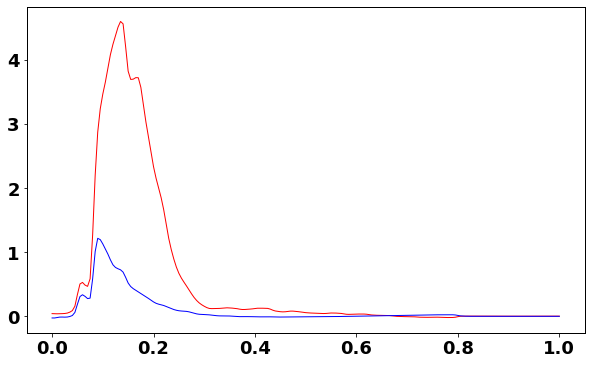

In [41]:
plt.figure(figsize=(10,6))
plt.plot(rho_tor_hal, ion_power_array_tor_hal, color='red')
plt.plot(rho_tor_hal, electron_power_array_tor_hal, color='blue')